In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:
data = pickle.load(open("../dataset/data_3D.pickle","rb"))

In [3]:
labels = pd.DataFrame(data['labels'], columns=['act', 'sub', 'lab', 'rep', 'frame'])

In [4]:
labels.describe()

,act,sub,lab,rep,frame
count,29789,29789,29789,29789,29789
unique,3,4,9,12,29789
top,Lunges,Isinsu,1,3,123
freq,12754,8827,10623,3815,1


In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29789 entries, 0 to 29788
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   act     29789 non-null  object
 1   sub     29789 non-null  object
 2   lab     29789 non-null  object
 3   rep     29789 non-null  object
 4   frame   29789 non-null  object
dtypes: object(5)
memory usage: 1.1+ MB


In [6]:
data['poses'].shape

(29789, 3, 25)

In [7]:
labels.iloc[:,:4].drop_duplicates().groupby(by=['act','sub','lab']).count()

rep
act    sub    lab     
Lunges Hugues 1     12
              4     10
              6     10
       Isinsu 1     11
              4     10
              6     10
       Sena   1     11
              4     10
              6     11
       Vidit  1     12
              4     10
              6     10
Plank  Hugues 1      7
              7      5
              8     10
       Isinsu 1      8
              7      5
              8     10
       Sena   1     11
              7     11
              8     11
       Vidit  1      7
              7      9
              8      9
SQUAT  Hugues 1     10
              2      5
              3      6
              4      5
              5      5
       Isinsu 1     10
              2      8
              3      7
              4      7
              5      6
       Sena   1     11
              10     9
              2      5
              3      5
              4      5
              5      6
       Vidit  1     10
              2      5
              3      5
              4      4
              5      7

In [8]:
labels.iloc[:,:4].drop_duplicates().groupby(by=['act','lab']).count()

sub  rep
act    lab          
Lunges 1     46   46
       4     40   40
       6     41   41
Plank  1     33   33
       7     30   30
       8     40   40
SQUAT  1     41   41
       10     9    9
       2     23   23
       3     23   23
       4     21   21
       5     24   24

In [9]:
labels.iloc[:,:4].drop_duplicates().groupby(by='act').count().rep

act
Lunges    127
Plank     103
SQUAT     141
Name: rep, dtype: int64

In [10]:
instruction_labels = {1 : "correct", 2 : "feet_too_wide", 3: "knees_inward", 4: "not_low_enough", 5: "front_bent", 6: "knee_passes_toe", 7: "arched_back", 8: "hunch_back", 10: "error"}

In [11]:
labels['lab'] = labels['lab'].astype('int')
labels['lab'] = labels['lab'].map(instruction_labels)

In [12]:
for act in labels.act.unique():
    print(labels[labels['act'] == act].rep.unique())

['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11']
['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12']
['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12']


In [13]:
labels

,act,sub,lab,rep,frame
0,SQUAT,Hugues,correct,1,123
1,SQUAT,Hugues,correct,1,124
2,SQUAT,Hugues,correct,1,125
3,SQUAT,Hugues,correct,1,126
4,SQUAT,Hugues,correct,1,127
...,...,...,...,...,...
29784,Plank,Isinsu,hunch_back,10,59722
29785,Plank,Isinsu,hunch_back,10,59723
29786,Plank,Isinsu,hunch_back,10,59724
29787,Plank,Isinsu,hunch_back,10,59725


In [14]:
data['poses'].shape

(29789, 3, 25)

In [15]:
def calculate_3D_angle(A: np.ndarray, B: np.ndarray, C: np.ndarray) -> float:
        if not (A.shape == B.shape == C.shape == (3,)):
            raise ValueError("Input arrays must all be of shape (3,).")

        ba = A - B
        bc = C - B

        cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
        angle = np.arccos(cosine_angle)

        return np.degrees(angle)

In [16]:
from typing import Dict

In [17]:
def calculate_of_angles(data: np.ndarray) -> pd.DataFrame:

    # mediapipe index joints --> Open pose index joints

    mp2op_dict = {0:0,1:None,2:16,3:None,4:None,5:15,6:None,7:18,8:17,9:None,10:None,11:5,12:2,13:6,14:3,
        15:7,16:4,17:None,18:None,19:None,20:None,21:None,22:None,23:12,24:9,25:13,26:10,27:14,
        28:11,29:19,30:22,31:None,32:None}

    angles_joints = {
        "left_knee": [27, 25, 23],
        "right_knee": [28, 26, 24],
        "left_elbow": [11, 13, 15],
        "right_elbow": [12, 14, 16],
        "left_shoulder": [13, 11, 12],
        "right_shoulder": [11, 12, 14],
        "left_hip": [11, 23, 25],
        "right_hip": [12, 24, 26]}

    angles_values = {
        "left_knee": [],
        "right_knee": [],
        "left_elbow": [],
        "right_elbow": [],
        "left_shoulder": [],
        "right_shoulder": [],
        "left_hip": [],
        "right_hip": []}

    for pose in data['poses']:
        for k in angles_values:

            angle = calculate_3D_angle(A = np.array([pose[0][mp2op_dict[angles_joints[k][0]]], 
                                            pose[1][mp2op_dict[angles_joints[k][0]]], 
                                            pose[2][mp2op_dict[angles_joints[k][0]]]]),
                                    B = np.array([pose[0][mp2op_dict[angles_joints[k][1]]], 
                                        pose[1][mp2op_dict[angles_joints[k][1]]], 
                                        pose[2][mp2op_dict[angles_joints[k][1]]]]),
                                    C = np.array([pose[0][mp2op_dict[angles_joints[k][2]]], 
                                        pose[1][mp2op_dict[angles_joints[k][2]]], 
                                        pose[2][mp2op_dict[angles_joints[k][2]]]]))

            angles_values[k].append(angle)

    df_angles = pd.DataFrame(angles_values)
    return df_angles

In [18]:
df_angles  = calculate_of_angles(data)

In [19]:
df_angles

,left_knee,right_knee,left_elbow,right_elbow,left_shoulder,right_shoulder,left_hip,right_hip
0,167.455608,172.221420,161.891089,156.794372,99.557699,100.189390,175.869505,174.656520
1,165.422781,170.596107,160.043919,153.645161,99.740084,100.525754,174.906872,175.458800
2,162.825017,168.208123,157.478636,149.462242,99.977563,100.793195,172.839533,175.276172
3,159.607962,165.029685,154.201990,145.308846,100.253448,100.798647,169.860558,173.482732
4,155.860505,161.165659,149.942374,141.762281,100.567232,100.566127,166.194988,170.643770
...,...,...,...,...,...,...,...,...
29784,143.079022,153.437403,168.945410,168.986919,96.020196,102.095830,120.276659,125.714158
29785,139.010266,149.015094,168.816960,167.741440,95.590011,102.249456,118.626253,123.369471
29786,134.943461,144.577343,168.710317,166.257546,95.193684,102.371717,117.277265,121.284510
29787,130.995897,140.448729,168.684560,164.968251,94.936578,102.407229,116.230624,119.666528


In [20]:
labels

,act,sub,lab,rep,frame
0,SQUAT,Hugues,correct,1,123
1,SQUAT,Hugues,correct,1,124
2,SQUAT,Hugues,correct,1,125
3,SQUAT,Hugues,correct,1,126
4,SQUAT,Hugues,correct,1,127
...,...,...,...,...,...
29784,Plank,Isinsu,hunch_back,10,59722
29785,Plank,Isinsu,hunch_back,10,59723
29786,Plank,Isinsu,hunch_back,10,59724
29787,Plank,Isinsu,hunch_back,10,59725


In [21]:
df_concat = pd.concat([labels,df_angles],axis=1)

In [22]:
df_concat.to_csv("data_with_angles.csv", index=False)

In [23]:
df_concat = pd.read_csv("data_with_angles.csv")

In [24]:
df_concat[(df_concat['act'] == 'SQUAT') & (df_concat['lab'] == 'knees_inward')].describe()

,rep,frame,left_knee,right_knee,left_elbow,right_elbow,left_shoulder,right_shoulder,left_hip,right_hip
count,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000
mean,3.421791,11593.640777,123.571851,123.995845,139.372783,142.652623,106.059372,112.569951,123.744204,128.461957
std,1.765252,5831.959541,39.468926,41.426573,31.027142,30.801975,9.729368,9.322060,36.639459,36.149526
min,1.000000,1701.000000,44.668082,39.936165,44.825632,49.136716,84.693066,94.221052,46.771780,49.148584
25%,2.000000,9597.250000,87.445107,88.280076,137.510425,143.328052,97.975914,105.268497,93.901133,98.925384
50%,3.000000,13430.500000,127.233863,127.757752,143.420895,153.318758,106.892985,109.757529,129.271086,134.082518
75%,5.000000,17401.750000,163.135956,168.632543,161.932720,161.610380,114.732836,119.068481,156.328889,163.945826
max,7.000000,17865.000000,176.625093,178.776254,179.749072,176.601579,124.864621,136.557696,172.685396,174.414989


In [25]:
df_concat['lab'].unique()

array(['correct', 'feet_too_wide', 'knees_inward', 'not_low_enough',
       'front_bent', 'error', 'knee_passes_toe', 'arched_back',
       'hunch_back'], dtype=object)

<Axes: >

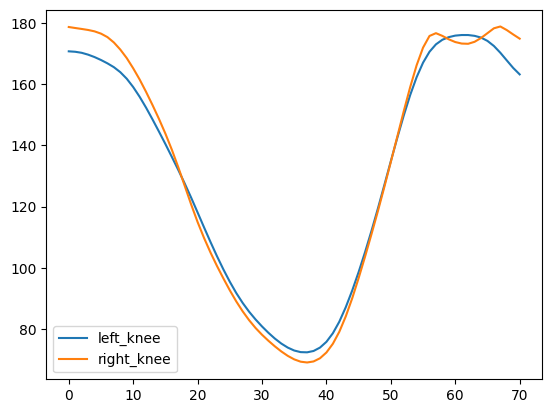

In [26]:
df_concat[(df_concat['act'] == 'SQUAT') 
& (df_concat['lab'] == 'knees_inward') 
& (df_concat['sub'] == 'Hugues') 
& (df_concat['rep'] == 1)].reset_index(drop=True)[['left_knee','right_knee']].plot()

<Axes: >

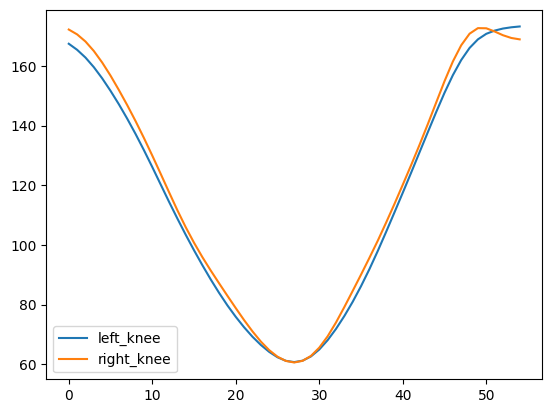

In [27]:
df_concat[(df_concat['act'] == 'SQUAT') 
& (df_concat['lab'] == 'correct')
& (df_concat['sub'] == 'Hugues')
& (df_concat['rep'] == 1)].reset_index(drop=True)[['left_knee','right_knee']].plot()

In [28]:
df_angles

,left_knee,right_knee,left_elbow,right_elbow,left_shoulder,right_shoulder,left_hip,right_hip
0,167.455608,172.221420,161.891089,156.794372,99.557699,100.189390,175.869505,174.656520
1,165.422781,170.596107,160.043919,153.645161,99.740084,100.525754,174.906872,175.458800
2,162.825017,168.208123,157.478636,149.462242,99.977563,100.793195,172.839533,175.276172
3,159.607962,165.029685,154.201990,145.308846,100.253448,100.798647,169.860558,173.482732
4,155.860505,161.165659,149.942374,141.762281,100.567232,100.566127,166.194988,170.643770
...,...,...,...,...,...,...,...,...
29784,143.079022,153.437403,168.945410,168.986919,96.020196,102.095830,120.276659,125.714158
29785,139.010266,149.015094,168.816960,167.741440,95.590011,102.249456,118.626253,123.369471
29786,134.943461,144.577343,168.710317,166.257546,95.193684,102.371717,117.277265,121.284510
29787,130.995897,140.448729,168.684560,164.968251,94.936578,102.407229,116.230624,119.666528


In [ ]:
#feet too wide - zbyt szeroko ustawione stopy
# knees inward - kolana do wewnątrz
# not low enough - nie wystarczająco nisko
# front bent - przód zgięty
# knee passes toe - kolano mija palce
# arched back - wygięte plecy
# hunch back - zgarbione plecy

In [43]:
for act in df_concat.act.unique():
    print(act)
    print(5 * "-")
    for lab in df_concat[df_concat['act'] == act].lab.unique():
        if not lab in ['correct','error']:
            print(lab)
    print()

SQUAT
-----
feet_too_wide
knees_inward
not_low_enough
front_bent

Lunges
-----
knee_passes_toe
not_low_enough

Plank
-----
arched_back
hunch_back

